In [29]:
import sys
sys.path.append("..")

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
import torch
import stackstac
from pystac_client import Client
import boto3
import xarray as xr
import numpy as np
import os
import rioxarray
from box import Box
import yaml

from src.datamodule import ClayDataModule
from src.model_clay_v1 import ClayMAEModule

In [43]:
def plot_rgb(stack):
    stack.sel(band=[1, 2, 3]).plot.imshow(
        rgb="band", vmin=0, vmax=2000, col_wrap=6
    )
    plt.show()
    
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


def load_model(ckpt, device="cuda"):
    torch.set_default_device(device)

    model = ClayMAEModule.load_from_checkpoint(
        ckpt, metadata_path="../configs/metadata.yaml", shuffle=False, mask_ratio=0
    )
    model.eval()

    return model.to(device)


def prep_datacube(stack, lat, lon, device):
    platform = "naip"

    # Extract mean, std, and wavelengths from metadata
    metadata = Box(yaml.safe_load(open("../configs/metadata.yaml")))
    mean = []
    std = []
    waves = []
    for band in stack.band:
        mean.append(metadata[platform].bands.mean[str(band.values)])
        std.append(metadata[platform].bands.std[str(band.values)])
        waves.append(metadata[platform].bands.wavelength[str(band.values)])

    transform = v2.Compose(
        [
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    datetimes = stack.time.values.astype("datetime64[s]").tolist()
    times = [normalize_timestamp(dat) for dat in datetimes]
    week_norm = [dat[0] for dat in times]
    hour_norm = [dat[1] for dat in times]

    # Prep lat/lon embedding
    latlons = [normalize_latlon(lat, lon)] * len(times)
    lat_norm = [dat[0] for dat in latlons]
    lon_norm = [dat[1] for dat in latlons]

    # Prep pixels
    pixels = torch.from_numpy(stack.data.astype(np.float32))
    pixels = transform(pixels)

    # Prepare additional information
    return {
        "platform": platform,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
        ),
        "pixels": pixels.to(device),
        "gsd": torch.tensor(stack.gsd.values, device=device),
        "waves": torch.tensor(waves, device=device),
    }


def generate_embeddings(model, datacube):
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

    # The first embedding is the class token, which is the
    # overall single embedding. We extract that for PCA below.
    return unmsk_patch[:, 0, :].cpu().numpy()


/opt/conda/envs/claymodel/lib/python3.10/site-packages/pystac_client/item_search.py:848: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


dataset:  <xarray.DataArray (band: 4, y: 12290, x: 9940)> Size: 489MB
[488650400 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 80kB 5.55e+05 5.55e+05 ... 5.609e+05 5.609e+05
  * y            (y) float64 98kB 4.165e+06 4.165e+06 ... 4.157e+06 4.157e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
dataset:  <xarray.DataArray (band: 4, y: 12280, x: 9940)> Size: 488MB
[488252800 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 80kB 5.439e+05 5.439e+05 ... 5.499e+05 5.499e+05
  * y            (y) float64 98kB 4.165e+06 4.165e+06 ... 4.157e+06 4.157e+06
    spatial_ref  i

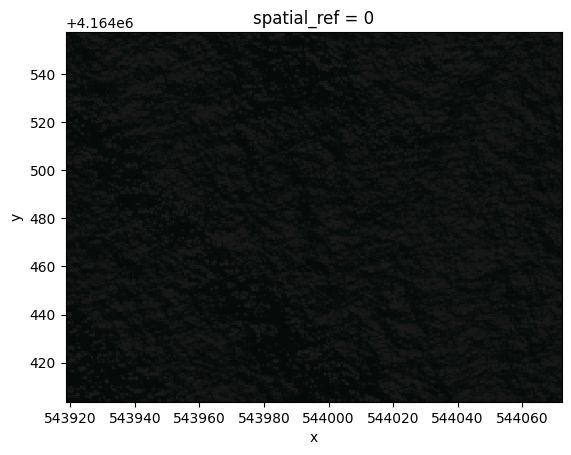

In [36]:
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
PLATFORM_NAME = "naip"


save_dir = "/home/ubuntu/data_naip_test/ca/2020/sf/"
os.makedirs(save_dir, exist_ok=True)

search_query = {
    "collections": [PLATFORM_NAME],
    "bbox": [-122.6, 37.6, -122.35, 37.85],  # Part of San Francisco, CA
    "datetime": f"{year}-01-01T00:00:00Z/{year+1}-01-01T00:00:00Z",
}

client = Client.open(STAC_API)

items = client.search(**search_query)

stackstac_datasets = []
granule_names = []

# Iterate over the granule names and fetch the corresponding StackSTAC data arrays
for item in items.get_all_items()[0:2]:
    assets = item.assets
    dataset = rioxarray.open_rasterio(item.assets["image"].href).sel(band=[1, 2, 3, 4])
    print("dataset: ", dataset)
    granule_name = item.assets["image"].href.split('/')[-1]
    stackstac_datasets.append(dataset)
    granule_names.append(granule_name)
    
    

# Function to tile dataset into 256x256 image chips and drop any excess border regions
def tile_dataset(dataset, granule_name):
    # Reorder dimensions to have (time, band, y, x)
    print("dataset.band: ", dataset.band)
    dataset = dataset.transpose("band", "y", "x")

    # Crop the dataset to remove excess border regions
    cropped_dataset = dataset.isel(x=slice(1, -1), y=slice(1, -1))

    # Determine the number of tiles in x and y dimensions
    num_x_tiles = cropped_dataset.x.size // 256
    num_y_tiles = cropped_dataset.y.size // 256

    # Iterate over each tile
    tiles = []
    for x_idx in range(num_x_tiles):
        for y_idx in range(num_y_tiles):
            # Calculate the coordinates for this tile
            x_start = x_idx * 256
            y_start = y_idx * 256
            x_end = x_start + 256
            y_end = y_start + 256

            # Extract the tile from the cropped dataset
            tile = cropped_dataset.isel(x=slice(x_start, x_end), y=slice(y_start, y_end))
            print(tile.shape)

            # Save the tile as a GeoTIFF
            tile_path = f"{save_dir}/{granule_name[:-4]}_{x_idx}_{y_idx}.tif"
            #tile.rio.to_raster(tile_path)
            print(tile)
            tiles.append(tile)
            
    return tiles
    


# Tile each dataset
for dataset, granule_name in zip(stackstac_datasets[0:2], granule_names[0:2]):
    tiles = tile_dataset(dataset, granule_name)
    
tile_0 = tiles[0]

plot_rgb(tile_0)


In [39]:
# Calculate the centroid
centroid_x = (tile_0.x * tile_0).sum() / tile_0.sum()
centroid_y = (tile_0.y * tile_0).sum() / tile_0.sum()

# Print or use the centroid coordinates
print("Centroid X:", centroid_x.item())
print("Centroid Y:", centroid_y.item())

lon = centroid_x.item()
lat = centroid_y.item()

Centroid X: 543996.7639614863
Centroid Y: 4164481.0515281498


In [48]:
model = load_model(
    # ckpt="s3://clay-model-ckpt/v0.5.3/mae_v0.5.3_epoch-29_val-loss-0.3073.ckpt",
    ckpt="../checkpoints/v0.5.3/mae_v0.5.3_epoch-08_val-loss-0.3150.ckpt",
    device="cuda",
)
datacube = prep_datacube(tile_0, lat, lon, model.device)
embeddings = generate_embeddings(model, datacube)

pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-30)
# All points
plt.scatter(stack.time, pca_result, color="blue")

# Cloudy images
plt.scatter(stack.time[0], pca_result[0], color="green")
plt.scatter(stack.time[2], pca_result[2], color="green")

# After fire
plt.scatter(stack.time[-5:], pca_result[-5:], color="red")

plt.show()

BoxKeyError: "'1'"